# Example of Retrieval

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from typing import List, Tuple
import random

## Data loading and inspection

In [2]:
DATA_DIR = Path('../data')
CSV_PATH = DATA_DIR / 'dataset2.csv'
NPZ_BOW_PATH = DATA_DIR / 'bovw_vectors_kmeans_1000.npz'

In [3]:
df = pd.read_csv(CSV_PATH)
npz_bovw = np.load(NPZ_BOW_PATH, allow_pickle=True)

In [4]:
npz_bovw

NpzFile '../data/bovw_vectors_kmeans_1000.npz' with keys: bovw_vectors, kmeans_centers, filenames

In [5]:
X_bovw = npz_bovw['bovw_vectors']
centers = npz_bovw['kmeans_centers']
filenames_npz = npz_bovw['filenames']
print('BoVW shape:', X_bovw.shape)
print('Centers shape:', centers.shape)
print('Filenames length:', len(filenames_npz))
print('First 3 filenames NPZ:', filenames_npz[:3])

BoVW shape: (79998, 1000)
Centers shape: (1000, 64)
Filenames length: 79998
First 3 filenames NPZ: ['Abstract_Expressionism/aaron-siskind_acolman-1-1955.jpg'
 'Abstract_Expressionism/aaron-siskind_chicago-6-1961.jpg'
 'Abstract_Expressionism/aaron-siskind_gloucester-16a-1944.jpg']


In [6]:
styles = set()

for filename in filenames_npz.astype(str):
    style = filename.split('/')[0]
    if style not in styles:
        print(style)
    styles.add(style)

print('Unique styles found:', styles)

Abstract_Expressionism
Color_Field_Painting
Contemporary_Realism
Cubism
Early_Renaissance
Expressionism
Fauvism
High_Renaissance
Impressionism
Action_painting
Analytical_Cubism
Art_Nouveau_Modern
Baroque
Northern_Renaissance
Pointillism
Pop_Art
Post_Impressionism
Realism
Rococo
Mannerism_Late_Renaissance
Minimalism
Naive_Art_Primitivism
New_Realism
Romanticism
Ukiyo_e
Symbolism
Synthetic_Cubism
Unique styles found: {'Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau_Modern', 'Early_Renaissance', 'Romanticism', 'Fauvism', 'Mannerism_Late_Renaissance', 'Northern_Renaissance', 'New_Realism', 'Symbolism', 'Naive_Art_Primitivism', 'Minimalism', 'Impressionism', 'Baroque', 'Abstract_Expressionism', 'Synthetic_Cubism', 'High_Renaissance', 'Pop_Art', 'Realism', 'Color_Field_Painting', 'Rococo', 'Contemporary_Realism', 'Cubism', 'Ukiyo_e', 'Pointillism', 'Post_Impressionism'}


In [7]:
row_norms = np.linalg.norm(X_bovw, axis=1)
print('Row norms: min={:.4f} median={:.4f} max={:.4f}'.format(row_norms.min(), np.median(row_norms), row_norms.max()))
print('Row sums:  min={:.4f} median={:.4f} max={:.4f}'.format(X_bovw.sum(1).min(), np.median(X_bovw.sum(1)), X_bovw.sum(1).max()))
print('Value range: [{:.4f}, {:.4f}]'.format(X_bovw.min(), X_bovw.max()))

Row norms: min=0.0000 median=1.0000 max=1.0000
Row sums:  min=0.0000 median=18.3779 max=24.3912
Value range: [0.0000, 1.0000]


## IN-BOVW retrieval

In [ ]:
# Retrieval over existing BoVW using cosine similarity

# Ensure L2 normalization
X_norm = X_bovw / (np.linalg.norm(X_bovw, axis=1, keepdims=True) + 1e-12)
filename_to_idx = {fn: i for i, fn in enumerate(filenames_npz.astype(str))}


def retrieve_topk_by_vector(query_vec: np.ndarray, k: int = 10, exclude_index: int = None) -> List[Tuple[int, float]]:
    q = query_vec.astype(np.float32)
    q = q / (np.linalg.norm(q) + 1e-12)
    sims = X_norm @ q  # cosine similarity
    if exclude_index is not None:
        sims[exclude_index] = -np.inf
    idx = np.argsort(-sims)[:k]
    return [(int(i), float(sims[i])) for i in idx]


def retrieve_by_filename(fname: str, k: int = 10) -> pd.DataFrame:
    i = filename_to_idx[fname]
    q = X_norm[i]
    top = retrieve_topk_by_vector(q, k=k, exclude_index=i)
    rows = []
    for j, sim in top:
        rows.append({'rank': len(rows)+1, 'index': j, 'filename': str(filenames_npz[j]), 'similarity': sim})
    return pd.DataFrame(rows)

# example
sample_fname = str(filenames_npz[random.randint(0, len(filenames_npz)-1)])
print('Query:', sample_fname)
df_nn = retrieve_by_filename(sample_fname, k=10)
print(df_nn.iloc[0]['filename'])
print(df_nn)

Query: Expressionism/amedeo-modigliani_landscape.jpg
Symbolism/kuzma-petrov-vodkin_portrait-of-n-l-1922.jpg
   rank  index                                           filename  similarity
0     1  77335  Symbolism/kuzma-petrov-vodkin_portrait-of-n-l-...    0.743745
1     2   9507  Expressionism/paula-modersohn-becker_mother-wi...    0.743179
2     3  68140  Realism/camille-corot_dunkirk-the-fishing-dock...    0.742186
3     4  14797  Impressionism/camille-pissarro_potato-harvest-...    0.737687
4     5  77280  Symbolism/kuzma-petrov-vodkin_grapes-and-apple...    0.737665
5     6  36726  Realism/camille-corot_the-rhone-three-women-on...    0.737233
6     7  39986  Impressionism/pierre-auguste-renoir_seated-you...    0.736338
7     8  14066  Impressionism/arkhip-kuindzhi_view-on-moscow-f...    0.736334
8     9  67306  Romanticism/ivan-aivazovsky_pushkin-at-the-top...    0.736042
9    10  43817  Realism/vasily-vereshchagin_himalayan-ponies-1...    0.734429


Query index: 7139
Query filename: Expressionism/franz-marc_tiger-1912-1.jpg
Stats: {'mean': 0.19319479167461395, 'median': 0.17420989274978638, 'std': 0.10989885032176971, 'min': 0.0, 'max': 0.8544000387191772}
Percentiles [1,5,10,50,90,95,99]: [0.         0.04951485 0.07006171 0.17420989 0.34662192 0.40099499
 0.50234943]


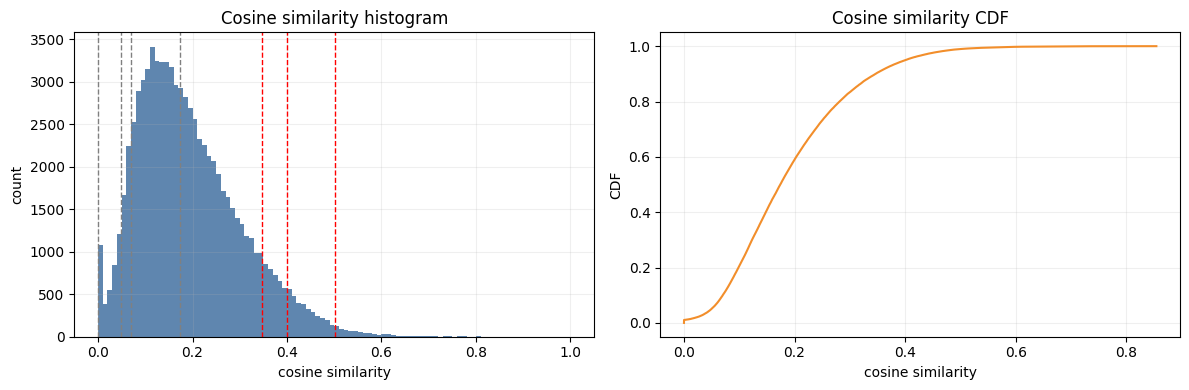

In [9]:
# Cosine similarity distribution for a random BoVW vector
import numpy as np
import matplotlib.pyplot as plt

# Ensure normalized matrix
if 'X_norm' not in globals():
    X_norm = X_bovw / (np.linalg.norm(X_bovw, axis=1, keepdims=True) + 1e-12)

rng = np.random.default_rng(42)
N = X_norm.shape[0]
q_idx = int(rng.integers(N))
q_fname = str(filenames_npz[q_idx])

sims = X_norm @ X_norm[q_idx]
sims[q_idx] = np.nan
valid = ~np.isnan(sims)
s = sims[valid]

stats = {
    'mean': float(np.mean(s)),
    'median': float(np.median(s)),
    'std': float(np.std(s)),
    'min': float(np.min(s)),
    'max': float(np.max(s)),
}
qs = np.percentile(s, [1,5,10,50,90,95,99])

print('Query index:', q_idx)
print('Query filename:', q_fname)
print('Stats:', stats)
print('Percentiles [1,5,10,50,90,95,99]:', qs)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Histogram
axes[0].hist(s, bins=100, range=(0.0, 1.0), color='#4e79a7', alpha=0.9)
for p, v in zip([1,5,10,50,90,95,99], qs):
    axes[0].axvline(v, color='red' if p>=90 else 'gray', linestyle='--', linewidth=1)
axes[0].set_title('Cosine similarity histogram')
axes[0].set_xlabel('cosine similarity')
axes[0].set_ylabel('count')
axes[0].grid(True, alpha=0.2)

# CDF
s_sorted = np.sort(s)
cdf = np.linspace(0, 1, s_sorted.size)
axes[1].plot(s_sorted, cdf, color='#f28e2b')
axes[1].set_title('Cosine similarity CDF')
axes[1].set_xlabel('cosine similarity')
axes[1].set_ylabel('CDF')
axes[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

## Query image retrieval

In [ ]:
# Query image -> BoVW -> cosine retrieval 

# Paths
IPCA_MEAN_PATH = DATA_DIR / 'ipca_mean.npy'
IPCA_COMP_PATH = DATA_DIR / 'ipca_components.npy'
GLOB_SCALE_PATH = DATA_DIR / 'global_pca_scale.npz'

ipca_mean = np.load(IPCA_MEAN_PATH).astype(np.float32) 
ipca_components = np.load(IPCA_COMP_PATH).astype(np.float32)
_scale = np.load(GLOB_SCALE_PATH)
gmin = _scale['gmin'].astype(np.float32)
gmax = _scale['gmax'].astype(np.float32)

# Ensure normalized dataset matrix
if 'X_norm' not in globals():
    X_norm = X_bovw / (np.linalg.norm(X_bovw, axis=1, keepdims=True) + 1e-12)

filename_to_idx = {fn: i for i, fn in enumerate(filenames_npz.astype(str))}

def _require_sift():
    if not hasattr(cv2, "SIFT_create"):
        raise ImportError("SIFT is required.")
    return cv2.SIFT_create()

def compute_sift_descriptors(img_path: str, max_desc: int = 1800) -> np.ndarray:
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")
    sift = _require_sift()
    kps, desc = sift.detectAndCompute(img, None)
    if desc is None or desc.size == 0:
        return np.empty((0, 128), dtype=np.float32)
    desc = desc.astype(np.float32)
    # Select top by L2 norm like in BoVW generation pipeline
    norms = np.linalg.norm(desc, axis=1)
    keep = np.argsort(-norms)[:max_desc]
    return desc[keep]

def ipca_project(desc128: np.ndarray, mean: np.ndarray, comps: np.ndarray) -> np.ndarray:
    if desc128.size == 0:
        return np.empty((0, comps.shape[0]), dtype=np.float32)
    Xc = desc128 - mean.reshape(1, -1)
    return (Xc @ comps.T).astype(np.float32)

def clamp_to_global_range(desc_proj: np.ndarray, gmin: np.ndarray, gmax: np.ndarray) -> np.ndarray:
    if desc_proj.size == 0:
        return desc_proj
    return np.clip(desc_proj, gmin.reshape(1, -1), gmax.reshape(1, -1))

def bovw_from_projected(desc_proj: np.ndarray, centers: np.ndarray) -> np.ndarray:
    K = centers.shape[0]
    if desc_proj.size == 0:
        return np.zeros(K, dtype=np.float32)
    # Squared distances to all K centers
    d2 = ((desc_proj[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
    a = np.argmin(d2, axis=1)
    hist = np.bincount(a, minlength=K).astype(np.float32)
    return hist

def retrieve_by_image(img_path: str, k: int = 10) -> pd.DataFrame:
    d128 = compute_sift_descriptors(img_path, max_desc=1800)
    d64 = ipca_project(d128, ipca_mean, ipca_components)
    d64 = clamp_to_global_range(d64, gmin, gmax)
    q_hist = bovw_from_projected(d64, centers)
    q = q_hist / (np.linalg.norm(q_hist) + 1e-12)
    sims = X_norm @ q
    idx = np.argsort(-sims)[:k]
    rows = []
    for rank, j in enumerate(idx, 1):
        fname = str(filenames_npz[j])
        rows.append({
            'rank': rank,
            'index': int(j),
            'filename': fname,
            'similarity': float(sims[j]),
        })
    hits = pd.DataFrame(rows)
    if {'filename','author','pic_name'}.issubset(df.columns):
        hits = hits.merge(df[['filename','author','pic_name']], on='filename', how='left')
    return hits

# Example:
query_path = "image.png"
hits = retrieve_by_image(query_path, k=10)
display(hits[['rank','similarity','filename','author','pic_name']])

,rank,similarity,filename,author,pic_name
0,1,0.782938,Mannerism_Late_Renaissance/jacopo-pontormo_jos...,Jacopo Pontormo,Joseph Revealing Himself To His Brothers
1,2,0.775605,Baroque/anthony-van-dyck_portrait-of-maria-lou...,Anthony Van Dyck,Portrait Of Maria Louisa De Tassis
2,3,0.772250,Realism/vincent-van-gogh_blind-man-sitting-in-...,Vincent Van Gogh,Blind Man Sitting In Interior(1)
3,4,0.770932,Realism/thomas-eakins_study-of-dr-agnew-for-th...,Thomas Eakins,Study Of Dr Agnew For The Agnew Clinic
4,5,0.765199,Symbolism/william-blake_satan-smiting-job-with...,William Blake,Satan Smiting Job With Boils 1826
5,6,0.763547,Romanticism/alexander-orlowski_self-portrait.jpg,Alexander Orlowski,Self Portrait
6,7,0.763191,Rococo/jean-marc-nattier_madame-de-la-porte-17...,Jean Marc Nattier,Madame De La Porte 1754
7,8,0.761256,Realism/william-adolphe-bouguereau_on-greve-18...,William Adolphe Bouguereau,On Greve 1896
8,9,0.755886,Realism/vincent-van-gogh_peasant-woman-with-sh...,Vincent Van Gogh,Peasant Woman With Shawl Over Her Head Seen Fr...
9,10,0.755664,Impressionism/edgar-degas_the-tub-1886.jpg,Edgar Degas,The Tub 1886
